In [1]:
###############################################################################
# Author: Carlos Bobed
# Date: Nov 2020
# Comments: code to merge codetables, translate them and use them to compress
# Modifications:
###############################################################################

In [1]:
import codeTest.test as t
t.testing()

ModuleNotFoundError: No module named 'codeTest'

Now we have to merge different CTs and compare the compression rates

In [5]:
## method to read for the Vreeken's codetable format 
## we don't need it to be a generator 
## we do label each code and honor the order in the code table (length, support, lexicographical)
## following Pierre's suggestion, we keep track of the codes and the transaction IDs 
def read_codetable(filename, load_all): 
    codes = {}
    label = 0 
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in file: 
            item_line = list(filter(None, line.rstrip('\n').split(' ')))
            ## only_used => those codes whose usage is > 0
            ## we get the last token, check whether it ends with )
            ## then, we get exactly the contents and check whether the first 
            ## component is different from 0
            if (item_line[-1].endswith(')')): 
                usage,support = item_line[-1][1:-1].split(',')
                if (load_all or int(usage) != 0):
                    codes[label]={'code': item_line[:-1], 'usage':int(usage), 'support':int(support)}
                    label+=1
    return codes    

## read information from the analysis to get back to the .dat file and select them
## we can cluster them according just to the items, or to the transactions themselves
## added the bidir table 
def read_analysis_table_bidir (filename): 
    db_dat_table = {}
    dat_db_table = {}
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        # skip the first  lines
        for i in range(15): 
            file.readline()
        current_line = file.readline()
        while (current_line != "\n"): 
            aux = current_line.split()[0].split('=>')
            db_dat_table[int(aux[0])] = int(aux[1])
            dat_db_table[int(aux[1])] = int(aux[0])
            current_line = file.readline()
    return db_dat_table, dat_db_table

def convert_int_codetable (codetable, analysis_table): 
    converted = {}
    for label in codetable: 
        translated_code = [ analysis_table[int(item)] for item in codetable[label]['code']]
        converted[label] = {'code_int':translated_code, 
                            'code_set':set(translated_code)}
    return converted


## naive way of merging the codetables 
## for convenience we work here with integers (we kept the codetables as string tokens to be able to handle the vector models)
def merge_codetables (codetables): 
    merged = {}
    non_colision_labelbase = 0
    for ct in codetables: 
        for label in ct: 
            current_label = str(non_colision_labelbase) + '_' + str(label)
            merged[current_label] = ct[label]
        non_colision_labelbase +=1
    # we keep track of the codes that are duplicated
    to_omit = set() 
    merged_key_list = list(merged.keys())
    for i in range(len(merged_key_list)): 
        if merged_key_list[i] not in to_omit: 
            for j in range(i+1, len(merged_key_list)): 
                if merged_key_list[j] not in to_omit:
                    # depending on how the table has been obtained it might or not have the code_set field
                    ## converted using the analysis table (convert_int_codetable) => it has 
                    ## loaded from file => it hasn't 
                    if 'code_set' in merged[merged_key_list[i]]: 
                        set_i = merged[merged_key_list[i]]['code_set'] 
                    else:
                        set_i = set([int(item) for item in merged[merged_key_list[i]]['code']])
                    if 'code_set' in merged[merged_key_list[j]]: 
                        set_j = merged[merged_key_list[j]]['code_set']
                    else: 
                        set_j = set([int(item) for item in merged[merged_key_list[j]]['code']])
                    if set_i == set_j: 
                        to_omit.add(merged_key_list[j])
    # we get rid of the duplicated entries in the codetable
    [merged.pop(code) for code in to_omit]
     
    for label in merged: 
        if 'code_int' in merged[label]:
            merged[label]['code'] = [str(item) for item in merged[label]['code_int']]
        merged[label]['usage'] = 0
        merged[label]['support'] = 0
        
    return merged 


In [3]:
## to keep track of the transactions id in the database, we read them in a different method
def read_database_db (filename): 
    transactions = {}
    label = 0
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in open(filename, mode='rt', encoding='UTF-8'): 
            if (line.split(':')[0].isnumeric()): 
                aux = line.split(':')[1].rstrip('\n')
                words = filter(None,aux.split(' '))
                transactions[label] = list(words)
                label+=1
    return transactions

def read_database_dat(filename): 
    transactions = {}
    label = 0
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in open(filename, mode='rt', encoding='UTF-8'): 
            aux = line.rstrip('\n')
            words = filter(None,aux.split(' '))
            transactions[label] = list(words)
            label+=1
    return transactions

In [4]:
# Standard cover order
# |X|↓ suppD(X) ↓ lexicographically ↑

# Standard candidate order 
# suppD(X) ↓|X|↓ lexicographically ↑   

def calculate_transaction_cover(transaction, codetable): 
    item_set = set(transaction)
    codes = []
    current_code = 0
    while (len(item_set) != 0 and current_code < len(codetable) ):
        aux_code_set = set(codetable[current_code]['code'])
        if (aux_code_set.issubset(item_set)): 
            codes.append(current_code)
            item_set.difference_update(aux_code_set)
        current_code+=1
    return codes

def calculate_codetable_support(database, codetable): 
    # to speed up the calculations, we augment the codetable with the set version of the code
    for label in codetable: 
        codetable[label]['code_set'] = set([int(item) for item in codetable[label]['code']])
    
    for trans in database: 
        item_set = set([int(item) for item in database[trans]])
        ## we have to check all the codes in the code table 
        ## this might be expensive ... we could just get the sum of the supports in the different databases 
        ## note that this is additive so in a better implementation it wouldn't be a problem
        for label in codetable: 
            ## if the intersection of the code is complete with the transaction
            if len(codetable[label]['code_set'].intersection(item_set)) == len(codetable[label]['code_set']): 
                codetable[label]['support'] += 1
        
## Note that I cannot do it until I have the codetable 
def calculate_codetable_usage (database, codetable): 
    for label in codetable: 
        codetable[label]['code_set'] = set([int(item) for item in codetable[label]['code']])
    
    for trans in database: 
        remaining_item_set = set([int(item) for item in database[trans]])
        current_code = 0
        while len(remaining_item_set) != 0 and current_code < len(codetable): 
            if len(codetable[current_code]['code_set'].intersection(remaining_item_set)) == len(codetable[current_code]['code_set']): 
                codetable[current_code]['usage'] += 1
                remaining_item_set = remaining_item_set - codetable[current_code]['code_set']
            current_code +=1
            
        if len(remaining_item_set) != 0: 
            print('This codetable is not covering properly the database ... is the SCT added?')


def codetable_in_standard_cover_order(codetable): 
    # we have to be careful with singleton codes (strings) ... if they have more than one char, they were 
    # getting innerly sorted
    return {idx:{'code':sorted(codetable[label]['code']) if not isinstance(codetable[label]['code'], str) else codetable[label]['code'], 
             'support':codetable[label]['support'], 
             'usage':codetable[label]['usage']}
                for idx,label in enumerate(sorted(codetable.keys(), reverse=True, 
                                                  key = lambda x:(len(codetable[x]['code']) if not isinstance(codetable[x]['code'],str) else 1
                                                                  ,codetable[x]['support'])), 
                                          start=0)}



In [5]:
def build_SCT(database): 
    sct_codetable = {}
    for trans in database: 
        for singleton in [int(item) for item in database[trans]]: 
            
            if singleton not in sct_codetable: 
                sct_codetable[singleton] = {'code':str(singleton), 'support':0, 'usage':0}
            sct_codetable[singleton]['usage'] = sct_codetable[singleton]['usage'] + 1
            sct_codetable[singleton]['support'] = sct_codetable[singleton]['support'] + 1
    return sct_codetable

In [6]:
import math
num_bits = - math.log(5/8,2)
num_bits

0.6780719051126377

In [7]:
import math
def calculate_size_database_from_codetable(codetable): 
    sum_usage = 0
    size = 0.0
    for label in codetable: 
        sum_usage += codetable[label]['usage']
    for label in codetable: 
        if (codetable[label]['usage'] != 0): 
            num_bits = -math.log(codetable[label]['usage'] / sum_usage)
            size += codetable[label]['usage'] * num_bits
    return size

In [8]:
# Driver Code 
A = {10, 20, 30, 40, 80} 
B = {100, 30, 80, 40, 60} 
A = A-B
print (A - B) 
print (B - A) 
print(A)

{10, 20}
{100, 40, 80, 60, 30}
{10, 20}


In [9]:
database_name = 'connect'
database_filename = database_name + '.db'
database_model_filename = database_filename + '.vect'
codetable_filename = database_name+'-latest-SLIM.ct'


In [10]:
import os
ct = read_codetable(os.path.join('databases', codetable_filename), False)
ct2 = read_codetable(os.path.join('databases', codetable_filename), True)
db = read_database_db(os.path.join('databases', database_filename))

In [11]:
merged = merge_codetables([ct,ct2])

In [12]:
print(len(merged))
print(len(ct))
print(len(ct2))

1799
1672
1799


In [13]:
calculate_codetable_support(db,merged)

merged

merged_std = codetable_in_standard_cover_order(merged)
merged_std

calculate_codetable_usage(db, merged_std)

ct2

merged_std

In [15]:
# I still have to: 
# - build a non initialized singleton codetable 
# - calculate the size of the database from usages
# - calculate the ratio of the database compressed with the codetable, and the database compressed with the SCT. 


sct = build_SCT(db)

sct

sct_std = codetable_in_standard_cover_order(sct)

sct_std

In [16]:
merged_size = calculate_size_database_from_codetable (merged_std)
sct_size = calculate_size_database_from_codetable(sct_std)

NameError: name 'merged_std' is not defined

In [17]:
print(f'merged_size:{merged_size} sct_size:{sct_size} ratio:{merged_size/sct_size}')

NameError: name 'merged_size' is not defined

In [18]:
import os
## testing everything together (connect database)

database_name = 'connect'
database_db_filename = database_name + '.db'
database_dat_filename = database_name + '.dat'
database_model_filename = database_filename + '.vect'
database_analysis_filename = database_db_filename + '.analysis.txt'
codetable_filename = database_name+'-latest-SLIM.ct'

In [19]:
db_dat_table, dat_db_table = read_analysis_table_bidir(os.path.join('databases', database_analysis_filename))

In [20]:
## we calculate the compression rate in the .dat 
orig_codetable = read_codetable(os.path.join('databases', codetable_filename), True)
converted_orig_codetable = convert_int_codetable(orig_codetable, db_dat_table)
orig_dat_database = read_database_dat(os.path.join('databases', database_dat_filename))

In [21]:
print(len(converted_orig_codetable))
print(converted_orig_codetable[0])
print(orig_codetable[0])

1799
{'code_int': [91, 109, 127, 75, 55, 37, 19, 88, 106, 124, 72, 85, 16, 121, 82, 13, 118, 79, 10, 115, 1, 7, 76, 112, 4], 'code_set': {1, 4, 7, 10, 13, 16, 19, 37, 55, 72, 75, 76, 79, 82, 85, 88, 91, 106, 109, 112, 115, 118, 121, 124, 127}}
{'code': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '16', '18', '19', '23', '25', '26', '30', '32', '33', '35', '39', '42'], 'usage': 2404, 'support': 2404}


In [22]:
converted_orig_codetable = merge_codetables([converted_orig_codetable])
calculate_codetable_support(orig_dat_database, converted_orig_codetable)
converted_orig_codetable_sco = codetable_in_standard_cover_order(converted_orig_codetable)

In [23]:
print(len(converted_orig_codetable))
print(converted_orig_codetable['0_1'])
print(converted_orig_codetable_sco[0])

1799
{'code_int': [91, 109, 127, 75, 55, 37, 19, 88, 106, 124, 72, 85, 16, 121, 82, 13, 118, 79, 10, 115, 1, 7, 76, 4, 113], 'code_set': {1, 4, 7, 10, 13, 16, 19, 37, 55, 72, 75, 76, 79, 82, 85, 88, 91, 106, 109, 113, 115, 118, 121, 124, 127}, 'code': ['91', '109', '127', '75', '55', '37', '19', '88', '106', '124', '72', '85', '16', '121', '82', '13', '118', '79', '10', '115', '1', '7', '76', '4', '113'], 'usage': 0, 'support': 1363}
{'code': ['1', '10', '106', '109', '112', '115', '118', '121', '124', '127', '13', '16', '19', '37', '4', '55', '7', '72', '75', '76', '79', '82', '85', '88', '91'], 'support': 2404, 'usage': 0}


In [24]:
calculate_codetable_usage(orig_dat_database, converted_orig_codetable_sco)

In [25]:
sct_codetable = build_SCT(orig_dat_database)
sct_codetable_sco = codetable_in_standard_cover_order(sct_codetable)

In [26]:
orig_size = calculate_size_database_from_codetable (converted_orig_codetable_sco)
sct_size = calculate_size_database_from_codetable(sct_codetable_sco)
orig_ratio = orig_size / sct_size 
print(f'orig_ratio:{orig_ratio}')

orig_ratio:0.11404116846703768


In [27]:
orig_usage_array = [converted_orig_codetable_sco[i]['usage'] for i in converted_orig_codetable_sco]
orig_support_array = [converted_orig_codetable_sco[i]['support'] for i in converted_orig_codetable_sco]
orig_length_codes_array=[len(converted_orig_codetable_sco[i]['code']) for i in converted_orig_codetable_sco]

sct_usage_array = [sct_codetable_sco[i]['support'] for i in sct_codetable_sco]

In [28]:
print(len(set(orig_usage_array)))
print(len(set(orig_support_array)))
print(len(set(sct_usage_array)))

381
693
124


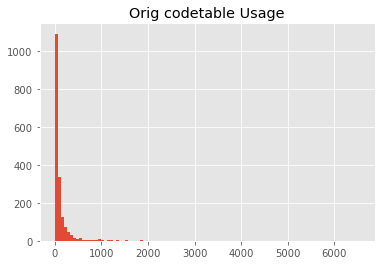

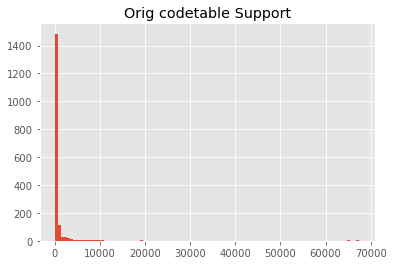

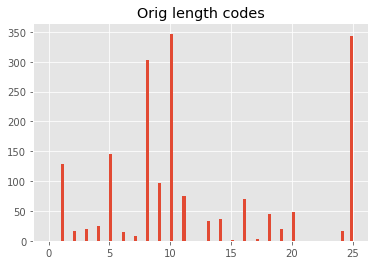

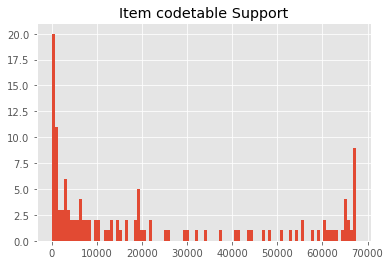

In [29]:
# we draw the histogram of the usage of the codes as well as the histogram of their support 
## as well as the histogram of the support of the items 

# again kudos for making things easier to 

# https://datatofish.com/plot-histogram-python/
# n = number of observations
# Range = maximum value – minimum value
# # of intervals =  √n
# Width of intervals =  Range / (# of intervals)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.hist(orig_usage_array, bins=100, range=[0, max(orig_usage_array)])
plt.title('Orig codetable Usage')
plt.show()

plt.hist(orig_support_array, bins=100, range=[0, max(orig_support_array)])
plt.title('Orig codetable Support')
plt.show()

plt.hist(orig_length_codes_array, bins=100, range=[0, max(orig_length_codes_array)])
plt.title('Orig length codes')
plt.show()

plt.hist(sct_usage_array, bins=100, range=[0, max(sct_usage_array)])
plt.title('Item codetable Support')
plt.show()



0.11399764858298939161 is the ratio of the original calculation (Vreekens' report file || dbSize columns) 

orig_ratio:0.11404116846703768
merged_ratio: 0.16585858752256222
merged_normalized_ratio: 0.17072056852230064



In [31]:
# Now the different codetables calculated each separately
# connect_trans_clust_i.ct
# connect_trans_clust_i.db.analysis.txt

codetables = []

for i in range(8):

    current_name = database_name+'_ord_200d_k8_trans_clust_'+str(i)+'_k8'
#     current_name = database_name+'_trans_clust_'+str(i)
    aux_db_dat_table, aux_dat_db_table = read_analysis_table_bidir(os.path.join('databases', current_name+'.db.analysis.txt'))
    aux_codetable = read_codetable(os.path.join('databases', database_name+'_ord_200d_k8_trans_clust_'+str(i)+'_k8.ct'), True)
#     aux_codetable = read_codetable(os.path.join('databases', database_name+'_trans_clust_'+str(i)+'.ct'), True)
    aux_converted_codetable = convert_int_codetable(aux_codetable, aux_db_dat_table)
    codetables.append(aux_converted_codetable)


In [ ]:
### Compression ratio of each of the partitions



In [32]:
sets_of_items = []
global_set = set()
for ct in codetables: 
    aux_set = set()
    for label in ct: 
        aux_set = aux_set.union(ct[label]['code_set'])
    sets_of_items.append(aux_set)
    global_set = global_set.union(aux_set)

print(f'global:{len(global_set)} local:{[len(i) for i in sets_of_items]}')

# we print the jaccard similarities of the sets 
for idx,s in enumerate(sets_of_items): 
    dist= ['{:6.4}'.format(len(s.intersection(aux))/len(s.union(aux))) for aux in sets_of_items]
    print(f'{idx}: {dist}') 
    
inter = sets_of_items[0]
for s in sets_of_items: 
    inter = inter.intersection(s)
print(len(inter))

rest = [s.difference(inter) for s in sets_of_items]
print(f'{[len(s) for s in rest]}')

# we print the jaccard similarities of the sets 
## we get rid of the "core": those which are in all the partitions
for idx,s in enumerate(rest): 
    dist = ['{:6.4}'.format(len(s.intersection(aux))/len(s.union(aux))) for aux in rest]
    print(f'{idx}: {dist}') 
    
print('intersections')
for idx,s in enumerate(rest): 
    dist = ['{}'.format(len(s.intersection(aux))) for aux in rest]
    print(f'{idx}: {dist}') 


global:129 local:[90, 97, 95, 101, 93, 99, 101, 87]
0: ['   1.0', '0.8515', '0.8687', ' 0.819', '0.8866', '0.8713', ' 0.819', '0.9032']
1: ['0.8515', '   1.0', '0.8286', '0.8165', '0.8447', '0.8318', '0.8333', '0.7864']
2: ['0.8687', '0.8286', '   1.0', '0.8318', '0.8614', '0.8476', '0.8148', ' 0.802']
3: [' 0.819', '0.8165', '0.8318', '   1.0', '0.8131', '0.8349', '0.8532', ' 0.757']
4: ['0.8866', '0.8447', '0.8614', '0.8131', '   1.0', '0.8286', '0.7963', '0.8182']
5: ['0.8713', '0.8318', '0.8476', '0.8349', '0.8286', '   1.0', '0.8182', '0.8058']
6: [' 0.819', '0.8333', '0.8148', '0.8532', '0.7963', '0.8182', '   1.0', '0.7407']
7: ['0.9032', '0.7864', ' 0.802', ' 0.757', '0.8182', '0.8058', '0.7407', '   1.0']
70
[20, 27, 25, 31, 23, 29, 31, 17]
0: ['   1.0', '0.5161', '0.5517', '0.4571', '0.5926', '0.5806', '0.4571', '0.6087']
1: ['0.5161', '   1.0', '0.4857', '0.4872', '0.5152', '0.5135', '0.5263', '0.3333']
2: ['0.5517', '0.4857', '   1.0', '0.5135', '0.5484', '0.5429', '0.4737'

In [97]:
from gensim.models import Word2Vec
import numpy as np

model = Word2Vec.load(os.path.join('databases', database_model_filename)) 

# we print the jaccard similarities of the sets 
auxMax = -1.0
auxI = 0 
auxJ = 0
list_of_cts = [x for x in enumerate(sets_of_items)]
for (i,s) in list_of_cts: 
    for (j,t) in list_of_cts: 
        if (i != j) and auxMax < len(s.intersection(t))/len(s.union(t)): 
            auxI = i 
            auxJ = j
            auxMax = len(s.intersection(t))/len(s.union(t))
            
print(f'max sim: {auxI},{auxJ}, {auxMax}')

auxMerged = merge_codetables([codetables[auxI], codetables[auxJ]])

# sanity code
# aux_sets_of_items = []
# for ct in [codetables[auxI], codetables[auxJ]]: 
#     aux_set = set()
#     for label in ct: 
#         aux_set = aux_set.union(ct[label]['code_set'])
#     aux_sets_of_items.append(aux_set)
    
# for idx,s in enumerate(aux_sets_of_items): 
#     dist= ['{:6.4}'.format(len(s.intersection(aux))/len(s.union(aux))) for aux in aux_sets_of_items]
#     print(f'{idx}: {dist}') 

print(len(auxMerged))
print(len(codetables[auxI]))
print(len(codetables[auxJ]))

print(len([x for x in auxMerged if len(auxMerged[x]['code_int']) > 1]))
print(len([x for x in auxMerged if len(auxMerged[x]['code_int']) == 1]))
print(len([x for x in codetables[auxI] if len(codetables[auxI][x]['code_int']) > 1]))
print(len([x for x in codetables[auxI] if len(codetables[auxI][x]['code_int']) == 1]))
print(len([x for x in codetables[auxJ] if len(codetables[auxJ][x]['code_int']) > 1]))
print(len([x for x in codetables[auxJ] if len(codetables[auxJ][x]['code_int']) == 1]))

included = 0
for x in codetables[auxI]: 
    aux_set_i = codetables[auxI][x]['code_set']
    if (len(aux_set_i) > 1): 
        for y in codetables[auxJ]: 
            aux_set_j = codetables[auxJ][y]['code_set']
            if len(aux_set_i.intersection(aux_set_j)) == len(aux_set_i): 
                included+=1
                break
print(f'I in J {included} inclusions found')
included = 0
for x in codetables[auxJ]: 
    aux_set_i = codetables[auxJ][x]['code_set']
    if (len(aux_set_i) > 1): 
        for y in codetables[auxI]: 
            aux_set_j = codetables[auxI][y]['code_set']
            if len(aux_set_i.intersection(aux_set_j)) == len(aux_set_i): 
                included+=1
                break
            
print(f'J in I {included} inclusions found')

partial = 0
for x in codetables[auxI]: 
    aux_set_i = codetables[auxI][x]['code_set']
    if (len(aux_set_i) > 1): 
        for y in codetables[auxJ]: 
            aux_set_j = codetables[auxJ][y]['code_set']
            if (len(aux_set_i.intersection(aux_set_j)) / len(aux_set_i) ) > 0.70: 
                partial+=1
                break
print(f'I in J {partial} partial inclusions found')
partial = 0
for x in codetables[auxJ]: 
    aux_set_i = codetables[auxJ][x]['code_set']
    if (len(aux_set_i) > 1): 
        for y in codetables[auxI]: 
            aux_set_j = codetables[auxI][y]['code_set']
            if (len(aux_set_i.intersection(aux_set_j)) / len(aux_set_i) ) > 0.70: 
                partial+=1
                break
            
print(f'J in I {partial} partial inclusions found')



max sim: 0,7, 0.9032258064516129
1057
503
638
964
93
413
90
551
87
I in J 85 inclusions found
J in I 92 inclusions found
I in J 177 partial inclusions found
J in I 279 partial inclusions found


In [65]:
codetables[auxI][0]

{'code_int': [127,
  124,
  121,
  109,
  106,
  103,
  91,
  88,
  85,
  82,
  75,
  55,
  52,
  37,
  34,
  31,
  19,
  16,
  13,
  100,
  49,
  72,
  69,
  118,
  10,
  66,
  46,
  79,
  1,
  63,
  76,
  28,
  26,
  23,
  40,
  45],
 'code_set': {1,
  10,
  13,
  16,
  19,
  23,
  26,
  28,
  31,
  34,
  37,
  40,
  45,
  46,
  49,
  52,
  55,
  63,
  66,
  69,
  72,
  75,
  76,
  79,
  82,
  85,
  88,
  91,
  100,
  103,
  106,
  109,
  118,
  121,
  124,
  127},
 'code': ['127',
  '124',
  '121',
  '109',
  '106',
  '103',
  '91',
  '88',
  '85',
  '82',
  '75',
  '55',
  '52',
  '37',
  '34',
  '31',
  '19',
  '16',
  '13',
  '100',
  '49',
  '72',
  '69',
  '118',
  '10',
  '66',
  '46',
  '79',
  '1',
  '63',
  '76',
  '28',
  '26',
  '23',
  '40',
  '45'],
 'usage': 0,
 'support': 0}

In [33]:
print(f'{[(i,sct_codetable_sco[i]["support"]) for i in sorted(inter)]}') 
print(f'{[(i,sct_codetable_sco[i]["support"]) for i in sorted(global_set.difference(inter)) if i in sct_codetable_sco]}') 




[(1, 67469), (2, 67465), (3, 67245), (5, 67042), (6, 67040), (8, 66819), (9, 66710), (10, 66041), (13, 65204), (16, 64301), (19, 61616), (23, 58869), (24, 57856), (26, 55333), (27, 54352), (31, 46933), (34, 41180), (37, 34167), (40, 29016), (41, 25889), (43, 22251), (45, 20324), (46, 19896), (47, 19545), (48, 19221), (49, 19074), (50, 18996), (51, 18945), (52, 18883), (55, 16303), (58, 14460), (59, 13264), (60, 13113), (61, 12148), (62, 12024), (63, 10337), (64, 10287), (65, 9896), (66, 9557), (67, 8211), (68, 8177), (69, 7719), (72, 6847), (75, 6358), (77, 5949), (78, 5541), (80, 4769), (81, 4446), (82, 4242), (85, 3572), (88, 3090), (91, 2789), (95, 1785), (96, 1490), (98, 1275), (99, 1228), (100, 1214), (103, 1139), (106, 956), (109, 533), (113, 360), (114, 359), (116, 291), (117, 270), (118, 222), (119, 153), (120, 153), (121, 153), (124, 70), (127, 18)]
[(4, 67044), (7, 66928), (11, 65450), (12, 65265), (14, 65143), (15, 64839), (17, 63096), (18, 62352), (20, 61206), (21, 60723), 

In [ ]:
print([len(i) for i in codetables])


In [ ]:
orig_dat_database = read_database_dat(os.path.join('databases', database_dat_filename))

converted_merged_codetable = merge_codetables(codetables)


In [ ]:
print([len(ct) for ct in codetables])
print(sum([len(ct) for ct in codetables]))
print(len(converted_merged_codetable))


In [ ]:
calculate_codetable_support(orig_dat_database, converted_merged_codetable)
converted_merged_codetable_sco = codetable_in_standard_cover_order(converted_merged_codetable)


In [ ]:
calculate_codetable_usage(orig_dat_database, converted_merged_codetable_sco)

In [ ]:
sct_codetable = build_SCT(orig_dat_database)
sct_codetable_sco = codetable_in_standard_cover_order(sct_codetable)

In [ ]:
merged_size = calculate_size_database_from_codetable (converted_merged_codetable_sco)
sct_size = calculate_size_database_from_codetable(sct_codetable_sco)
merged_ratio = merged_size / sct_size 
print(f'merged_ratio:{merged_ratio}')

In [ ]:
converted_merged_codetable_sco[0]

In [ ]:
def prune_by_usage_threshold(codetable, threshold): 
    return {i:{'code':codetable[i]['code'], 
           'support':0, 
           'usage':0, 
           'code_set':codetable[i]['code_set']} for i in codetable if codetable[i]['usage'] > threshold or len(codetable[i]['code']) == 1}

In [ ]:
print(len(converted_orig_codetable_sco))
print(len({label:converted_orig_codetable_sco[label] for label in converted_orig_codetable_sco if converted_orig_codetable_sco[label]['usage']>0}))
print(len({label:converted_orig_codetable_sco[label] for label in converted_orig_codetable_sco if converted_orig_codetable_sco[label]['usage']>10}))

print(len(converted_merged_codetable_sco))
print(len({label:converted_merged_codetable_sco[label] for label in converted_merged_codetable_sco if converted_merged_codetable_sco[label]['usage']>0}))
print(len({label:converted_merged_codetable_sco[label] for label in converted_merged_codetable_sco if converted_merged_codetable_sco[label]['usage']>6}))


In [ ]:
pruned_merged_codetable = prune_by_usage_threshold(converted_merged_codetable_sco,10)
print(len(pruned_merged_codetable))

In [ ]:
calculate_codetable_support(orig_dat_database, pruned_merged_codetable)
pruned_merged_codetable_sco = codetable_in_standard_cover_order(pruned_merged_codetable)
calculate_codetable_usage(orig_dat_database, pruned_merged_codetable_sco)
merged_size = calculate_size_database_from_codetable (pruned_merged_codetable_sco)
sct_size = calculate_size_database_from_codetable(sct_codetable_sco)
merged_ratio = merged_size / sct_size 
print(f'merged_ratio:{merged_ratio}')

In [ ]:
merged_usage_array = [converted_merged_codetable_sco[i]['usage'] for i in converted_merged_codetable_sco if converted_merged_codetable_sco[i]['usage'] >0]
merged_support_array = [converted_merged_codetable_sco[i]['support'] for i in converted_merged_codetable_sco]
merged_length_array = [len(converted_merged_codetable_sco[i]['code']) for i in converted_merged_codetable_sco]

pruned_merged_usage_array = [pruned_merged_codetable_sco[i]['usage'] for i in pruned_merged_codetable_sco if pruned_merged_codetable_sco[i]['usage']>0]
pruned_merged_support_array = [pruned_merged_codetable_sco[i]['support'] for i in pruned_merged_codetable_sco]
pruned_merged_length_array = [len(pruned_merged_codetable_sco[i]['code']) for i in pruned_merged_codetable_sco]

In [ ]:
# we draw the histogram of the usage of the codes as well as the histogram of their support 
## as well as the histogram of the support of the items 

# again kudos for making things easier to 

# https://datatofish.com/plot-histogram-python/
# n = number of observations
# Range = maximum value – minimum value
# # of intervals =  √n
# Width of intervals =  Range / (# of intervals)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.hist(merged_usage_array, bins=100, range=[0, max(merged_usage_array)])
plt.title('Merged codetable Usage')
plt.show()

plt.hist(merged_support_array, bins=100, range=[0, max(merged_support_array)])
plt.title('Merged codetable Support')
plt.show()

plt.hist(merged_length_array, bins=100, range=[0, max(merged_length_array)])
plt.title('Merged codetable lengths')
plt.show()


In [ ]:
# we draw the histogram of the usage of the codes as well as the histogram of their support 
## as well as the histogram of the support of the items 

# again kudos for making things easier to 

# https://datatofish.com/plot-histogram-python/
# n = number of observations
# Range = maximum value – minimum value
# # of intervals =  √n
# Width of intervals =  Range / (# of intervals)

import matplotlib.pyplot as plt
import math

plt.style.use('ggplot')

#n = number of observations = 100
#Range = maximum value – minimum value = 91 – 1 = 90
# of intervals =  √n = √100 = 10
#Width of intervals =  Range / (# of intervals) = 90/10 = 9

def draw_pair_histograms(orig_array, merged_array, subfig1, subfig2, title1, title2): 
    n = max(len(orig_array),len(merged_array))
    x_low = min(min(orig_array), min(merged_array))
    x_high = max(max(orig_array), max(merged_array))
    intervals = math.ceil(math.sqrt(n))
    
    print (f'size orig: {len(orig_array)} -- size merged: {len(merged_array)}')
    print (f'min orig: {min(orig_array)} -- min merged: {min(merged_array)}')
    print (f'max orig: {max(orig_array)} -- max merged: {max(merged_array)}')
    
    hist_orig = subfig1.hist(orig_array, bins=intervals , range=[x_low, x_high])
    subfig1.set_title(title1)

    hist_merged = subfig2.hist(merged_array, bins=intervals ,  range=[x_low, x_high])
    subfig2.set_title(title2)

    y_max = max(max(hist_orig[0]), max(hist_merged[0])) * 1.05
    subfig1.set_ylim([0,y_max])
    subfig2.set_ylim([0,y_max])

fig,axs = plt.subplots(3,2)
fig.suptitle(database_name,  fontsize="x-large")
fig.set_figheight(15)
fig.set_figwidth(15)


draw_pair_histograms(orig_usage_array, merged_usage_array, axs[0,0], axs[0,1], 
                             'Original codetable Usage', 'Merged codetable Usage')
draw_pair_histograms(orig_support_array, merged_support_array, axs[1,0], axs[1,1], 
                             'Original codetable Support', 'Merged codetable Support')
draw_pair_histograms(orig_length_codes_array, merged_length_array, axs[2,0], axs[2,1], 
                             'Original codetable lengths', 'Merged codetable lengths')



In [ ]:
fig,axs = plt.subplots(3,2)
fig.suptitle(database_name,  fontsize="x-large")
fig.set_figheight(15)
fig.set_figwidth(15)


draw_pair_histograms( merged_usage_array, pruned_merged_usage_array, axs[0,0], axs[0,1], 
                              'Merged codetable Usage', 'Pruned')
draw_pair_histograms( merged_support_array, pruned_merged_support_array, axs[1,0], axs[1,1], 
                              'Merged codetable Support', 'Pruned')
draw_pair_histograms( merged_length_array, pruned_merged_length_array, axs[2,0], axs[2,1], 
                             'Merged codetable lengths', 'Pruned')
